In [1]:
from IPython.display import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use("huntstone")
import numpy as np
from multiprocessing import Pool
from functools import partial
from scipy.constants import c
import sys
sys.path.insert(0, "../../python/")
import eo_signal as eos
from plotting import makefig
import time
#npeaks = np.load("/home/keenan/eos_bpm/khuntstone/current_profiles/npeaks.npy")
#p2ps   = np.load("/home/keenan/eos_bpm/khuntstone/current_profiles/Idz.npy")

In [2]:
def get_sep(ind, d, angle):
    I, ti, Idt, sig, t_sig, gamma, t_gamma \
                   = eos.get_signal(ind, "GaP", d, 800e-9, 30e-15, angle, 1e-3, "cross")
    Sdt = eos.peak2peak(sig, t_sig)
    error_t = abs(Sdt - Idt)
    error_p = error_t/ Idt
    #if npeaks[ind] > 2:
    #    error = np.nan
    return error_t, error_p

def plot_result(errors_p, errors_t, ds, ths):
    # Compute extent (needs evenly spaced ds and ths)
    dd    = (ds[1]-ds[0])*1e6
    dmin  = ds[0]*1e6 - dd/2
    dmax  = ds[-1]*1e6 + dd/2
    dt    = ths[1] - ths[0]
    tmin  = ths[0] - dt/2
    tmax  = ths[-1] + dt/2
    ext       = [dmin, dmax, tmin, tmax]
    errp_plot = np.flipud(np.transpose(errors_p))
    errt_plot = np.flipud(np.transpose(errors_t*1e15))
    # Plot percentage
    fig1, ax1 = makefig(xlab = r'd [$\mu$m]', ylab = "Angle [deg.]")
    ax1.set_xticks(ds*1e6)
    img1      = ax1.imshow(errp_plot*100, cmap = 'CMRmap', extent = ext, aspect = 'auto')
    cbar      = plt.colorbar(mappable = img1, label = 'Avg. Error [%]')
    # Plot distance
    fig2, ax2 = makefig(xlab = r'd [$\mu$m]', ylab = "Angle [deg.]")
    ax2.set_xticks(ds*1e6)
    img2      = ax2.imshow(errt_plot, cmap = "CMRmap", extent = ext, aspect = 'auto')
    cbar      = plt.colorbar(mappable = img2, label = r'Avg. Error [fs]') 

In [5]:
ds       = np.array([25, 50, 75, 100])*1e-6
ths      = np.arange(10, 61, 5)
N        = 100
inds     = np.arange(0, N, 1)
errors_p = np.zeros((len(ds), len(ths)))
errors_t = np.zeros((len(ds), len(ths)))
N_p      = 4
start    = time.time()
for i in range(len(ds)):
    print(i+1, "of", len(ds))
    for j in range(len(ths)):
        pool  = Pool(N_p)
        errf  = partial(get_sep, d = ds[i], angle = ths[j])
        errt, errp   = zip(*pool.map(errf, inds))
        pool.close()
        pool.join()
        errors_p[i,j] = np.nanmean(errp)
        errors_t[i,j] = np.nanmean(errt)      
print(time.time() - start)

1 of 4
2 of 4
3 of 4
4 of 4
186.25006556510925


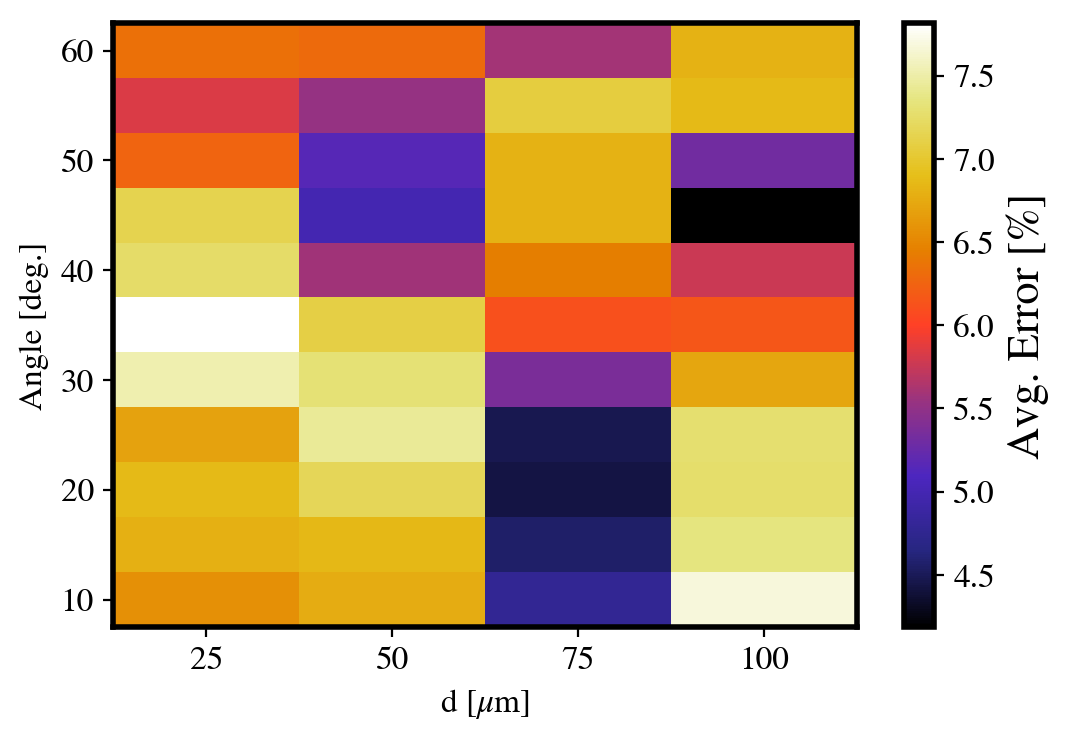

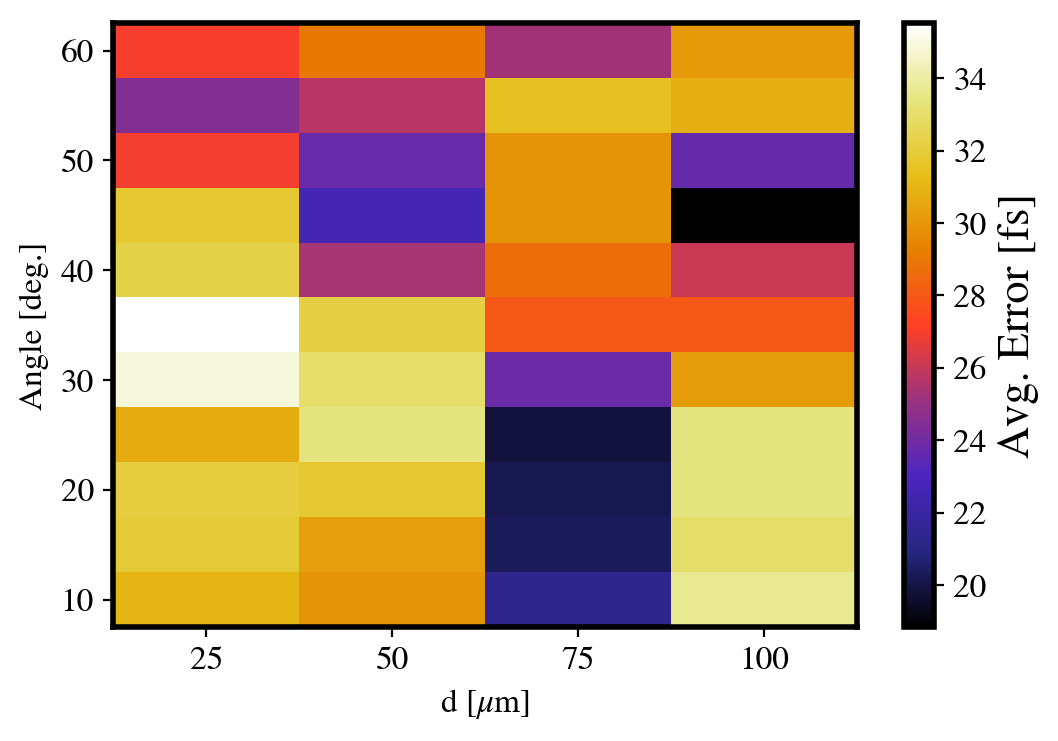

In [7]:
plot_result(errors_p, errors_t, ds, ths)

In [3]:
def get_peak(ind, r):
    I, ti, Idz, sig, t_sig, gamma, t_gamma \
                   = eos.get_signal(ind, "GaP", 100e-6, 800e-9, 30e-15, 15, r, "cross")
    return np.nanmax(sig)

In [5]:
# Parameter scan of offset from beam axis
d     = 100e-6
th    = 15
r0    = np.arange(1, 5.1, 0.5)*1e-3
dx    = np.linspace(-100, 100, 100)*1e-6
peak  = np.zeros([len(r0), len(dx)])
N     = 3134
N_p   = 4
inds  = np.arange(0, N, 1)
start = time.time()
for i in range(len(r0)):
    print(i+1, "of", len(r0))
    for j in range(len(dx)):
        smax = partial(get_peak, r = r0[i] + dx[j])
        pool  = Pool(N_p)
        peaks = pool.map(smax, inds)
        pool.close()
        pool.join()
        peak[i,j] = np.nanmean(peaks)
print(time.time()-start)

1 of 9
2 of 9
3 of 9
4 of 9
5 of 9
6 of 9
7 of 9
8 of 9
9 of 9
116413.7754600048


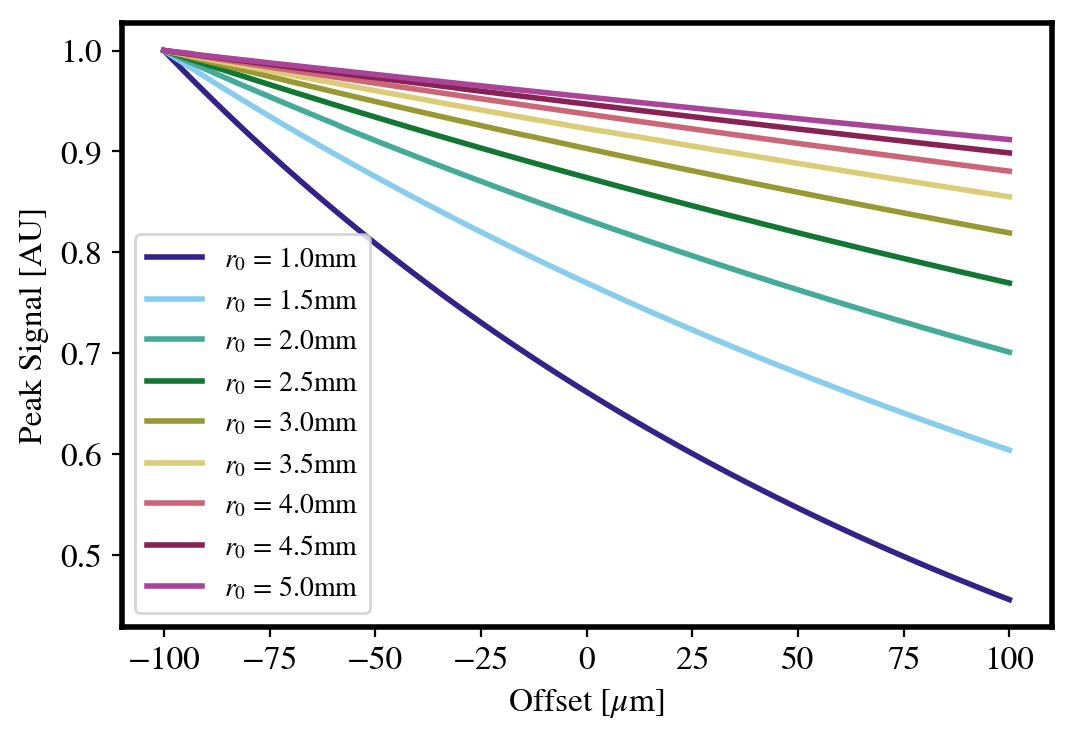

In [7]:
fig, ax = makefig(xlab = r'Offset [$\mu$m]', ylab = 'Peak Signal [AU]')
for i in range(len(r0)):
    lab = r'$r_0$ = ' + str(np.round(r0[i]*1e3,2)) + "mm"
    ax.plot(dx*1e6, peak[i,:] / max(peak[i,:]), label = lab)
ax.legend()
plt.show()